# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

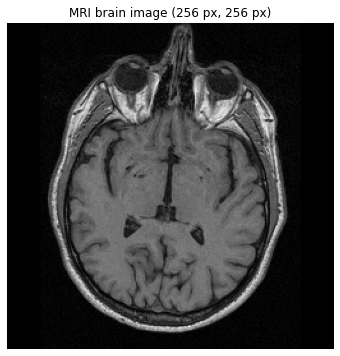

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

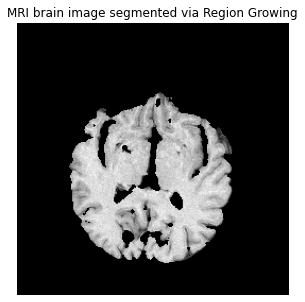

Number of pixels in brain: 16682


In [3]:
import cv2 as cv
import numpy as np

def get_untreated_neighbours(current_pixel, untreated, image_shape):
    pixel_line, pixel_col = current_pixel
    image_lines, image_cols = image_shape
    
    untreated_neighbours = []
    for delta_line in [-1, 0, +1]:
        neighbour_line = pixel_line + delta_line
        
        # If we are outside the image, skip these pixels.
        if neighbour_line < 0 or neighbour_line >= image_lines:
            continue
        
        for delta_col in [-1, 0, +1]:
            # If we are on current pixel, skip this pixel.
            if delta_line == 0 and delta_col == 0:
                continue
            
            neighbour_col = pixel_col + delta_col
            
            # If we are outside the image, skip these pixels.
            if neighbour_col < 0 or neighbour_col >= image_cols:
                continue
            
            # Add neighbour if not already treated.
            neighbour = (neighbour_line, neighbour_col)
            if untreated[neighbour]:
                untreated_neighbours.append(neighbour)
                
    return untreated_neighbours
    

def growing_criterion(neighbourhood_mean_val, neighbour_val, threshold):
    return abs(int(neighbourhood_mean_val) - int(neighbour_val)) < threshold
    

def region_growing(image, seed, threshold, neighbourhood_size):
    
    assert(neighbourhood_size >= 0)
    delta_lower = -(neighbourhood_size//2)
    delta_upper = +(neighbourhood_size//2)+1
        
    image_shape = image.shape
    output    = np.zeros(image_shape, dtype = np.bool_)
    untreated = np.ones (image_shape, dtype = np.bool_)
    
    pixels_to_treat = [seed]
    
    while pixels_to_treat:
        current_pixel = pixels_to_treat[-1]
        pixels_to_treat.pop()
        
        output[current_pixel] = True
        
        for neighbour in get_untreated_neighbours(current_pixel, untreated, image_shape):
            untreated[neighbour] = False
            
            neighbourhood_mean = np.mean(image[current_pixel[0]+delta_lower:current_pixel[0]+delta_upper, 
                                               current_pixel[1]+delta_lower:current_pixel[1]+delta_upper])
            
            if growing_criterion(neighbourhood_mean, image[neighbour], threshold):
                pixels_to_treat.append(neighbour)
                
    return output
        
        
# Region Growing parameters.
seed      = (140, 140)
threshold = 7
neighbourhood_size = 5

# Filters parameters.
structuring_element = cv.getStructuringElement(cv.MORPH_RECT, (2,2))
size_median_filter  = 5
                                               
# Segmenting.
mask = region_growing(brain_im, seed, threshold, neighbourhood_size)
mask = cv.morphologyEx(mask.astype(np.uint8), cv.MORPH_CLOSE, structuring_element)
mask = cv.medianBlur(mask.astype(np.uint8), size_median_filter)

# Display Segmentation Mask.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
masked_image = np.where(mask, brain_im, 0)
ax.imshow(masked_image, cmap='gray')
ax.set_title('MRI brain image segmented via Region Growing')
ax.axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

Parler de comment seed a été choisie et comment threshold a ete determiné. Parler de bouts de cerveau pas segmenté dans image finale, problème est que sont entouré par des pixels pour foncés qui du coup separent certains bouts du bout principal (processus s'arrete sur le boundary noir)

DISCUSSION.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 1.3 Contour detection (5pts)

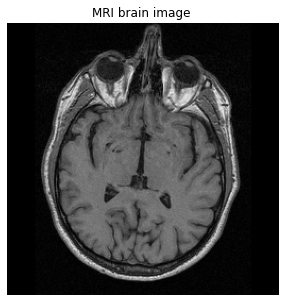

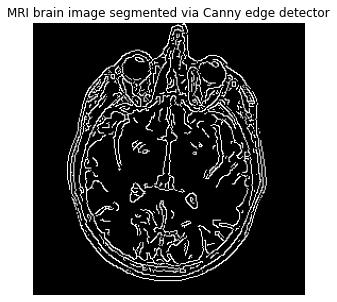

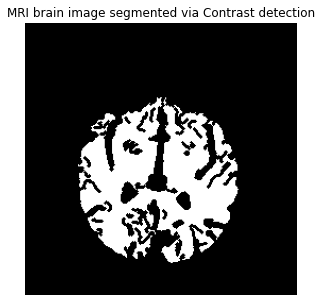

Number of pixels in brain: 12325


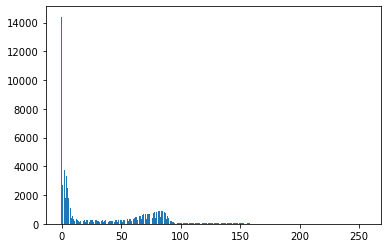

In [4]:
# Contour detection function
import scipy.ndimage as nd
import skimage.segmentation as seg
##

##Canny detector
brain = brain_im.copy() ##Make a copy of the image
##Plot the Image (serves as a reference)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(brain, cmap='gray')
ax.set_title('MRI brain image ')
ax.axis('off')
plt.show()

##Apply a median filter in order to reduce the noise while keeping the edges clear
brain = nd.median_filter(brain,size = 3)
##Apply the Canny edges detector
Canny_detector = cv.Canny(brain,80,50)
##Plot the Edges : 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Canny_detector, cmap='gray')
ax.set_title('MRI brain image segmented via Canny edge detector')
ax.axis('off')
plt.show()
##in order to extract the brain, we must first close the edges. First, create a structuring element and dilate the image with it
kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
dilated = cv.dilate(Canny_detector, kernel)
##cv.connectedcomponent needs an image with a background white to work well. Thus : we take the negatif of the image 
dilated = np.where(dilated>0,0,255)
##We isolate the brain area by connecting components at the seed (140,140) [pixel inside the brain]
_, segmented = cv.connectedComponents(dilated.astype(np.uint8))
mask         = segmented == segmented[seed]
##We print the resulting regions
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mask, cmap='gray')
ax.set_title('MRI brain image segmented via Contrast detection')
ax.axis('off')
plt.show()


##Plot the histogram
histogram, bin_edges = np.histogram(brain_im, bins=256, range=(0, 256))
plt.bar(range(0,256), histogram)

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

DISCUSSION.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 1.4 Additional method (5pts)

<BarContainer object of 256 artists>

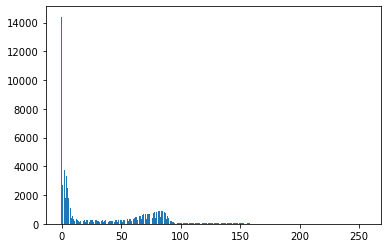

In [5]:
histogram, bin_edges = np.histogram(brain_im, bins=256, range=(0, 256))
plt.bar(range(0,256), histogram)

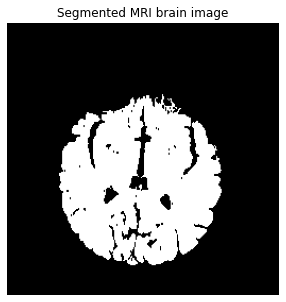

Number of pixels in brain: 16734


In [6]:
thresholded = np.logical_and(brain_im > 50, brain_im < 95).astype(np.uint8)
_, labels   = cv.connectedComponents(thresholded)
mask        = (labels == labels[seed]).astype(np.uint8)
mask        = cv.morphologyEx(mask, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (1,2)))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mask, cmap='gray')
ax.set_title('Segmented MRI brain image')
ax.axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

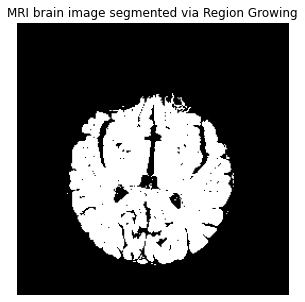

Number of pixels in brain: 16573


In [7]:
# TO BE REMOVED: FOR SOME REASON THE SMALL DOTS INSIDE BRAIN DON'T SEEM TO HAVE A LABEL, THEY ARE PROBABLY
# CLASSIFIED AS BACKGROUND, AND HENCE ARE UNDETECTABLE BY THIS ROUTINE

thresholded = np.logical_and(brain_im > 50, brain_im < 95).astype(np.uint8)
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresholded)

brain_label   = labels[seed]
circle_center = np.array(centroids[brain_label])
circle_radius = (stats[brain_label, cv.CC_STAT_WIDTH] + stats[brain_label, cv.CC_STAT_HEIGHT]) / 4

for label in range(num_labels):
    if stats[label, cv.CC_STAT_AREA] < 10:
        label_center = np.array(centroids[label])
        distance     = label_center - circle_center
        if np.sum(distance**2) < circle_radius**2:
            labels[labels == label] = brain_label

mask = labels == brain_label
            
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mask, cmap='gray')
ax.set_title('MRI brain image segmented via Region Growing')
ax.axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

Closing does close a bit of horizontal lines on the side of the brain, but that's acceptable. Connected components with stats .....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [8]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


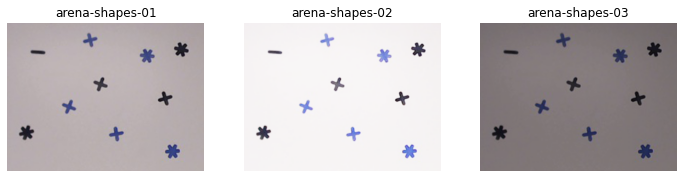

In [9]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

# WARNING: THIS FUNCTION IS NOT COMPLETED. MUST FIND A WAY TO LINK CLOSE COMPONENTS BECAUSE AS OF NOW STILL WRONG NUMBER OF OBJECTS

6
9


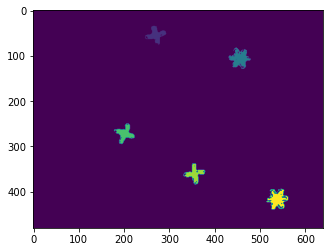

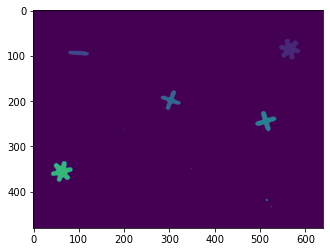

9
9


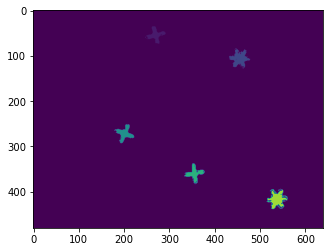

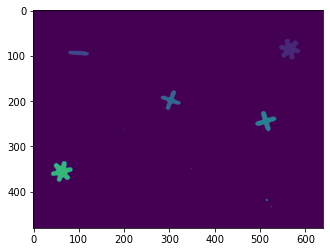

6
6


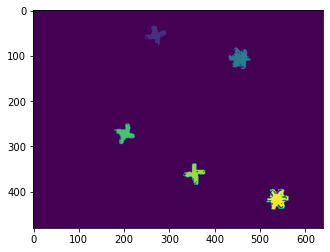

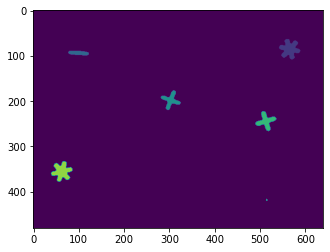

In [10]:
def detect_same_object(component1, component2):
    distance = np.linalg.norm(component1["centroid"] - component2["centroid"])
    radius_component1 = (component1["width"] + component1["height"]) / 4 
    radius_component2 = (component2["width"] + component2["height"]) / 4 

    if distance <= radius_component1 or distance <= radius_component2:
        return True
    
    return False
    

def get_components_from_mask(mask):
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask)

    # Merging close components that belong to same object, skipping background labeled 0.
    new_labels = {}
    for component1 in range(1, num_labels):
        parameters1 = {"centroid": np.array(centroids[component1]), "width": stats[component1, cv.CC_STAT_WIDTH], "height": stats[component1, cv.CC_STAT_HEIGHT]}
        for component2 in range(component1 + 1, num_labels):
            parameters2 = {"centroid": np.array(centroids[component2]), "width": stats[component2, cv.CC_STAT_WIDTH], "height": stats[component2, cv.CC_STAT_HEIGHT]}
            if detect_same_object(parameters1, parameters2):
                new_labels[component2] = component1
        
    # Lists all values of dictionary which are also keys. Needed to solve conflicts.
    key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
    while key_value_conflicts:
        for conflict in key_value_conflicts:
            new_labels[conflict] = new_labels[new_labels[conflict]]
        key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
    
    
    for old_component, new_component in new_labels.items():
        labels[labels == old_component] = new_component
        
    return labels
    
    
for image, name in zip(images, im_names):
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    
    image_hsv[:,:,2] = cv.equalizeHist(image_hsv[:,:,2])
    
    blue_mask  = cv.inRange(image_hsv, (90, 50, 5), (135, 255, 255))
    black_mask = cv.inRange(image_hsv, (0, 0, 0), (180, 255, 3))
    
    objects_blue  = get_components_from_mask(blue_mask)
    objects_black = get_components_from_mask(black_mask)

    print(len(np.unique(objects_blue))-1)
    print(len(np.unique(objects_black))-1)

    plt.imshow(objects_blue)
    plt.show()
    plt.imshow(objects_black)
    plt.show()

### 2.3 Total area (in pixels) of each color (5 pts)

In [11]:
# Add your implementation and discussion